In [1]:
!git clone https://github.com/vebrahimi1990/WideField_Denoising.git

fatal: destination path 'WideField_Denoising' already exists and is not an empty directory.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Input
import matplotlib.pyplot as plt
from tifffile import imwrite

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from WideField_Denoising import Model_2D_RCAN, datagenerator_2D

data_generator = datagenerator_2D.data_generator
make_generator = Model_2D_RCAN.make_generator

In [16]:
GT_image_dr = r'D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\test\raw.tif'
lowSNR_image_dr =r'D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\test\raw.tif'


model_save_directory = r"D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\microtubule_rcan_test.h5"  
save_image_dr = r"D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\test\test_results" 
save_parameters_dr = r"D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\test\test_results\param.csv"



In [17]:
patch_size =2048
n_patches = 1
n_channel =  0
add_noise =False
lp = 1.235

x_test, y_test,_,_ = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                    n_channel, threshold =0 ,ratio=1.0,lp=lp, augment=False, shuffle=False,
                                    add_noise=add_noise)

(2, 2, 2048, 2048)
2
The training set shape is: (2, 2048, 2048, 1)
The validation set shape is: (0, 2048, 2048, 1)


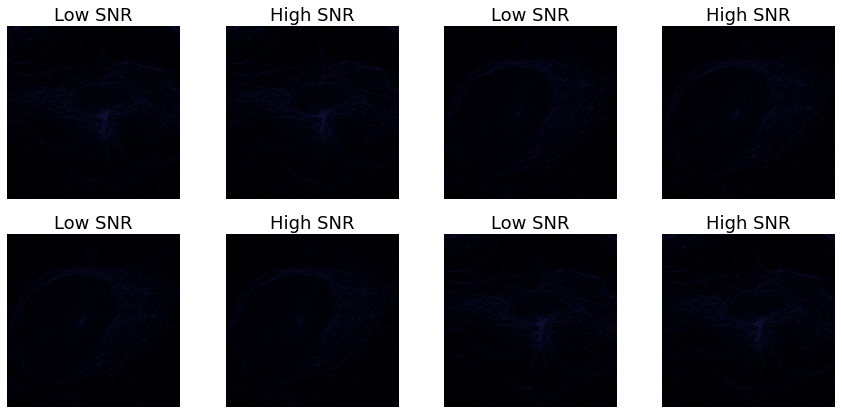

In [18]:
ix = np.random.randint(0,len(x_test),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [9]:
#UNet-RCAN Prediction
filters =[32,128,256]
num_filters = filters[0]
filters_cab=num_filters/8

num_RG=5
num_RCAB=5

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
generator.load_weights(model_save_directory)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction1[i],prediction2[i]= generator(x_test[i:i+1],training=False)
    prediction2[i] = generator(x_test[i:i+1],training=False)
    prediction1[i] = prediction1[i]/prediction1[i].max()
    prediction2[i] = prediction2[i]/prediction2[i].max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

In [19]:
#UNet or RCAN Prediction
filters =[16,64,128]

num_filters = filters[0]
r = 8
filters_cab=num_filters/r
num_RG=2
num_RCAB=5

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
generator.load_weights(model_save_directory)

prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction2[i] = generator(x_test[i:i+1],training=False)
    prediction2[i] = prediction2[i]/prediction2[i].max()
prediction2[prediction2<0]=0

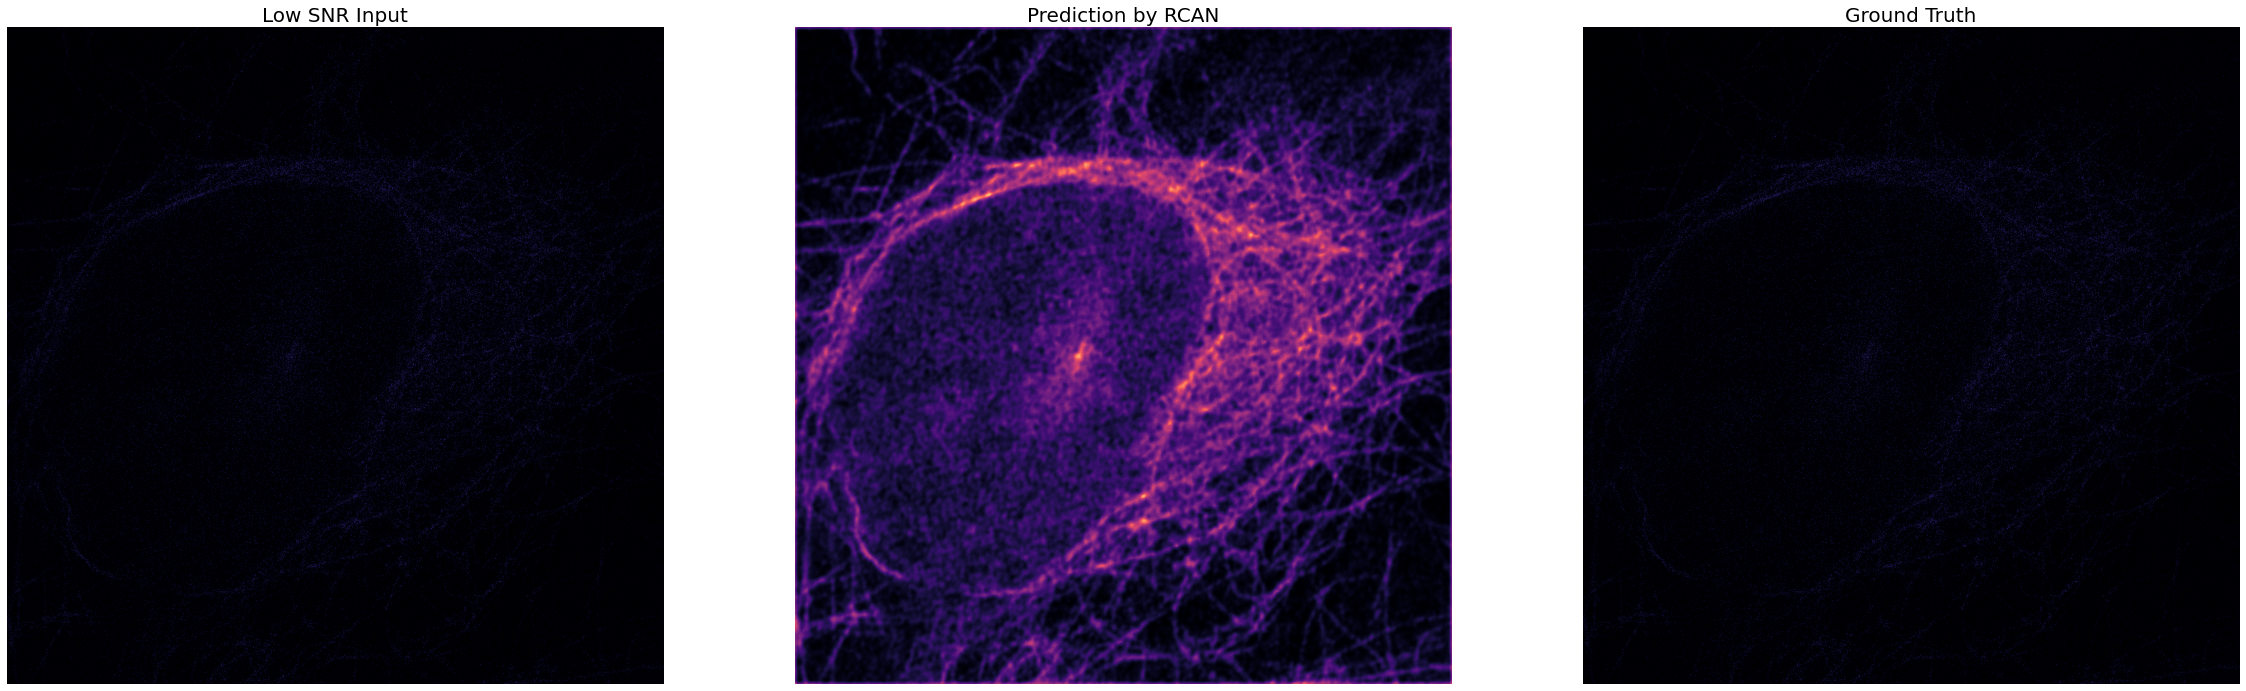

In [20]:
ix = np.random.randint(len(prediction2))
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 3, 1)
plt.imshow(x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by RCAN',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [13]:
pred2_test = prediction2*(2**16-1)
X_test = x_test*(2**16-1)
Y_test = y_test*(2**16-1)

pred2_test = pred2_test.astype(np.uint16)

X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/pred.tif', pred2_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/noisy.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/gt.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})

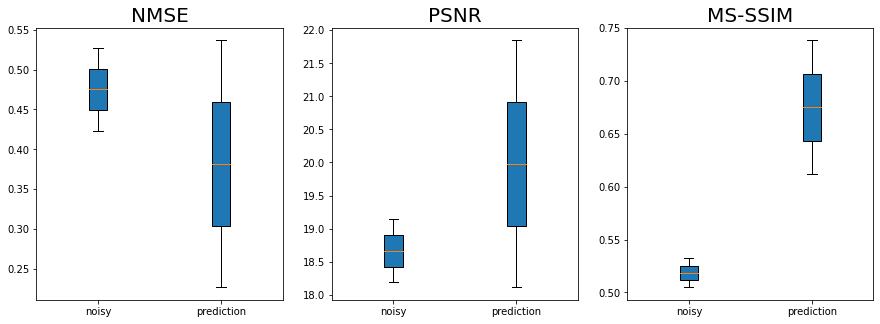

In [15]:
def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction2)))

imageq_param[0::2,:] = nmse_psnr_ssim(x_test,y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(prediction2,y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
labels = ['noisy', 'prediction']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE',fontsize=20)

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR',fontsize=20)

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM',fontsize=20)


np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")